In [1]:
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
import geopandas
from utilities.weatherFunctions import *

INFO:utilities:Initializing mypkg


# Using Baseline to calculate heatwaves using multiple definitions

There are two definitions of a heatwave that are more nuanced than the current definition used by the WMO. 

1. **Heat Index**: Heat index aka apparent temperature is based on work carried out by Robert G. Steadman in 1979 ("An Assessment of Sultriness, Parts I and II") where he discussed factors that would impact how hot a person would feel under certain conditions. It incorporates 21 parameters and assumptions: body mass (147.7 lbs), height (5'7"), actively walking (3.1 mph), clothing (pants and short sleeve shirt), heat tolerance, in the shade, etc. This formula became the "heat index". It is the traditional measurement of heat stress due to high temperatures and high humidity.
*Heat index is calculated for shady areas*

    The inputs to this are - temperature, relative humidity

    Equation:

    Heat Index = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH

    * T = ambient dry temperature (in Fahrenheit)
    * R = relative humidity (percentage)

2. **Wet Bulb Globe Temperature (WBGT)**: WBGT is an indicator of heat related stress on the human body at work (or play) in direct sunlight. It takes into account multiple atmospheric variables, including: temperature, humidity, wind speed, sun angle, and cloud cover.

    Equation:

    WBGT=0.7Tw+0.2Tg+0.1Td
    * Tw = Natural wet-bulb temperature (combined with dry-bulb temperature indicates humidity)
    * Tg = Globe thermometer temperature (measured with a globe thermometer, also known as a black globe thermometer)
    * Td = Dry-bulb temperature (actual air temperature)

**In this notebook, currently, Heat Index is calculated**


**References**

* https://www.weather.gov/ict/wbgt#:~:text=The%20Wet%20Bulb%20Globe%20Temperature,sun%20angle%2C%20and%20cloud%20cover.
* https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml



In [2]:
ds_tasmax = xr.open_mfdataset("../../data/gldas/tasmax/wld_cli_gldas2*", parallel = True)
ds_tasmin = xr.open_mfdataset('../../data/gldas/tasmin/wld_cli_gldas2*', parallel=True)
ds_rh = xr.open_mfdataset("../../data/gldas/relativehumidity/wld_cli_gldas2*", parallel = True)

## Read areas of interest

In [3]:
INDIA = geopandas.read_file("../../data/shapefiles/india_district/sh819zz8121.shp").to_crs("EPSG:4326")
CHENNAI = INDIA[INDIA["laa"] == "CHENNAI"]
PHILIPPINES  = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm2_psa_namria_20200529.shp')
MANILA = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin(['NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'])]

Explore the data

In [4]:
ds_rh['time'].values

array(['1948-01-01T13:30:00.000000000', '1948-01-02T13:30:00.000000000',
       '1948-01-03T13:30:00.000000000', ...,
       '2022-04-28T13:30:00.000000000', '2022-04-29T13:30:00.000000000',
       '2022-04-30T13:30:00.000000000'], dtype='datetime64[ns]')

In [5]:
ds_tasmin['time']

<xarray.DataArray 'time' (time: 27149)>
array(['1948-01-01T13:30:00.000000000', '1948-01-02T13:30:00.000000000',
       '1948-01-03T13:30:00.000000000', ..., '2022-04-28T13:30:00.000000000',
       '2022-04-29T13:30:00.000000000', '2022-04-30T13:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01T13:30:00 ... 2022-04-30T13:30:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [6]:
def clip_area(ds, area):

    ds.rio.write_crs("EPSG:4326", inplace=True)
    clipped_area = ds.rio.clip(area.geometry.values,all_touched=True, drop=True)

    return clipped_area

Prep the data to clip the area of interest

In [7]:
ds_tasmax=ds_tasmax.drop(['time_bnds'])
ds_rh=ds_rh.drop(['time_bnds'])
ds_tasmin=ds_tasmin.drop(['time_bnds'])

Clip area of inetrest from the larger dataset

In [8]:
chennai_tmax = clip_area(ds_tasmax, CHENNAI)
chennai_rh = clip_area(ds_rh, CHENNAI)
chennai_tmin = clip_area(ds_tasmin, CHENNAI)

In [9]:
manila_tmax = clip_area(ds_tasmax, MANILA)
manila_rh = clip_area(ds_rh, MANILA)
manila_tmin = clip_area(ds_tasmin, MANILA)

Check if data exists in the clipped xarrays

In [248]:
manila_rh.isel(lat = slice(0,1), lon = slice(1,2), time = slice(0,1))['RH_f_inst'].values

array([[[87.80255]]], dtype=float32)

The classification was created by the United States and hence, may not be applicable to hotter countries in the Global South

In [10]:
manila_hi = combine_tmax_rh(manila_tmax, manila_rh)
manila_hi['heat_index'] = manila_hi.apply(lambda x: calculate_heat_index(x['Tasmax_F'], x['RH_f_inst']), meta = (None, 'float64'), axis=1)

In [12]:
chennai_hi = combine_tmax_rh(chennai_tmax, chennai_rh)
chennai_hi['heat_index'] = chennai_hi.apply(lambda x: calculate_heat_index(x['Tasmax_F'], x['RH_f_inst']), axis=1)
chennai_hi['heat_index_classification'] = chennai_hi.apply(lambda x: classify_heat_index(x['heat_index'], x['Tasmax_F'], x['RH_f_inst']), axis=1)

/Users/wbdatalab/anaconda3/envs/heatwaves/lib/python3.11/site-packages/dask/dataframe/core.py:5967: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/Users/wbdatalab/anaconda3/envs/heatwaves/lib/python3.11/site-packages/dask/dataframe/core.py:5967: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  

In [256]:
manila_hi['year'] = manila_hi['time'].dt.year

Write monthly/daily files to a csv for future reference

In [278]:
manila_hi[manila_hi['year']>2016][['lat', 'lon', 'time', 'heat_index', 'Tasmax', 'RH_f_inst']].compute().to_csv('../../data/gldas/manila_heat_index_daily.csv')

In [264]:
manila_hi.groupby(['time', 'lat', 'lon']).max().reset_index()[['lat', 'lon', 'time', 'heat_index']].compute().to_csv('../../data/gldas/manila_heat_index_annual.csv')

In [96]:
chennai_hi['year'] = chennai_hi['time'].dt.year
chennai_hi['month'] = chennai_hi['time'].dt.month

In [125]:
chennai_hi.groupby(['year', 'month','lat', 'lon', 'heat_index_classification']).count().reset_index()[['year', 'month','lat', 'lon', 'heat_index_classification', 'spatial_ref_x']].compute().to_csv('../../data/gldas/chennai_heatindexclassification_month_count.csv')
chennai_hi.groupby(['year', 'month','lat', 'lon']).max().reset_index()[['year', 'month','lat', 'lon', 'heat_index']].compute().to_csv('../../data/gldas/chennai_heatindex_month_max.csv')

In [126]:
chennai_hi_df = pd.read_csv('../../data/gldas/chennai_heatindex_month_max.csv')
chennai_hic_df = pd.read_csv('../../data/gldas/chennai_heatindexclassification_month_count.csv')

In [279]:
manila_hi_df = pd.read_csv('../../data/gldas/manila_heat_index_daily.csv')

In [280]:
manila_hi_df.drop(columns = 'Unnamed: 0', inplace=True)

In [281]:
manila_hi_df

,lat,lon,time,heat_index,Tasmax,RH_f_inst
0,14.375,120.875,2017-01-01 13:30:00,90.580411,302.02130,70.539210
1,14.375,120.875,2017-01-03 13:30:00,94.389751,303.05627,69.362335
2,14.375,120.875,2017-01-05 13:30:00,94.422406,302.65894,73.660570
3,14.375,120.875,2017-01-10 13:30:00,85.794107,300.11206,82.463930
4,14.375,120.875,2017-01-11 13:30:00,82.643078,299.27930,84.869150
...,...,...,...,...,...,...
11671,14.875,121.125,2022-04-16 13:30:00,117.460039,306.14664,78.689200
11672,14.875,121.125,2022-04-23 13:30:00,112.112693,307.01690,66.183945
11673,14.875,121.125,2022-04-25 13:30:00,120.524138,307.76453,70.440704
11674,14.875,121.125,2022-04-26 13:30:00,117.536022,307.71213,67.686990


In [127]:
chennai_hi_df.drop(columns = 'Unnamed: 0', inplace=True)
chennai_hic_df.drop(columns = 'Unnamed: 0', inplace=True)

In [155]:
from datetime import datetime
#chennai_hic_df['time'] = chennai_hic_df.apply(lambda x: datetime(x['year'].astype(int), x['month'].astype(int), 1), axis=1)
chennai_hi_df['time'] = chennai_hi_df.apply(lambda x: datetime(x['year'].astype(int), x['month'].astype(int), 1), axis=1)

# Average number of days the city was in each classification of heat index

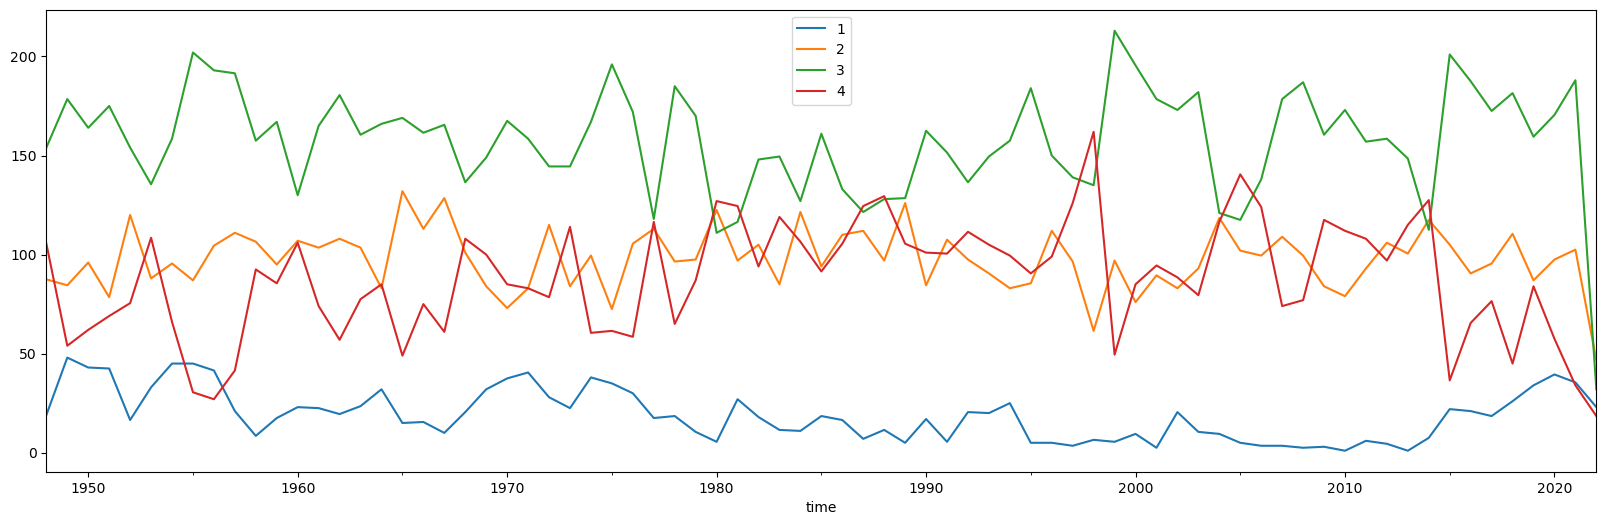

In [186]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,6))

df = chennai_hic_df.groupby([pd.Grouper(key ='time', freq='Y'), 'heat_index_classification', 'lat', 'lon']).sum().reset_index()
df = df.groupby(['time', 'heat_index_classification']).mean().reset_index()

for hic in [1,2,3,4]:
    df1 = df[df['heat_index_classification']==hic]
    df1.plot(x='time', y='spatial_ref_x', label = hic, ax=ax)

## Maximum heat index in a year across locations in Chennai

In [282]:
manila_hi_df[['lat', 'lon']].drop_duplicates()

,lat,lon
0,14.375,120.875
659,14.375,121.125
1298,14.625,120.875
1934,14.625,121.125
2564,14.875,120.875
3226,14.875,121.125


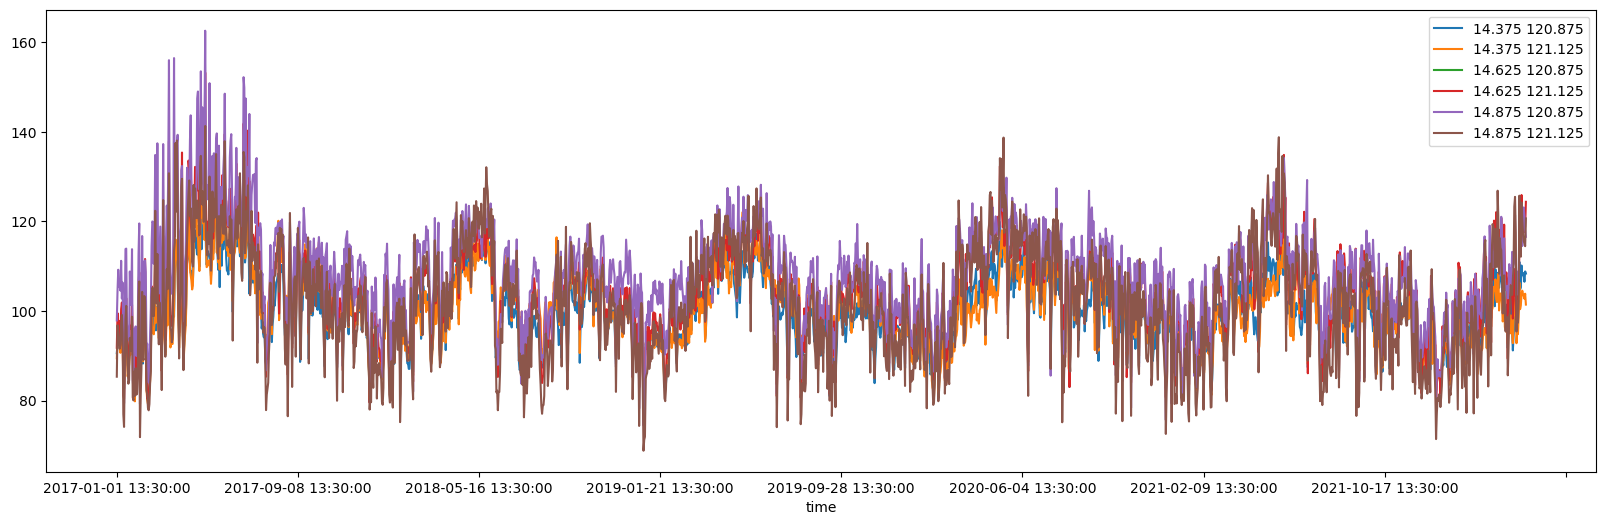

In [285]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,6))

df = manila_hi_df.groupby(['time', 'lat', 'lon']).max().reset_index()
#df = df.groupby(['time', 'lat', 'lon']).mean().reset_index()

for lat in [14.375, 14.625, 14.875]:
    for lon in [120.875, 121.125]:
        df1 = df[(df['lat']==lat)&(df['lon']==lon)]
        df1.plot(x='time', y='heat_index', label = str(lat)+' '+(str(lon)), ax=ax)